# Fish

In [4]:
%matplotlib inline 

import torch
import numpy as np
import random
import util.data_utils as pu
import util.utils as ut
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

ROOT_DIR = './data/images'
CSV_FILE = './data/data.csv'
OUTPUT_FILE = './output/log.txt'

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

y = encoder.fit_transform(np.array(['bac', 'ga', 'bac', 'go']))
print(y)
encoder.inverse_transform(0)

[0 1 0 2]


'bac'

## Exploratory analysis

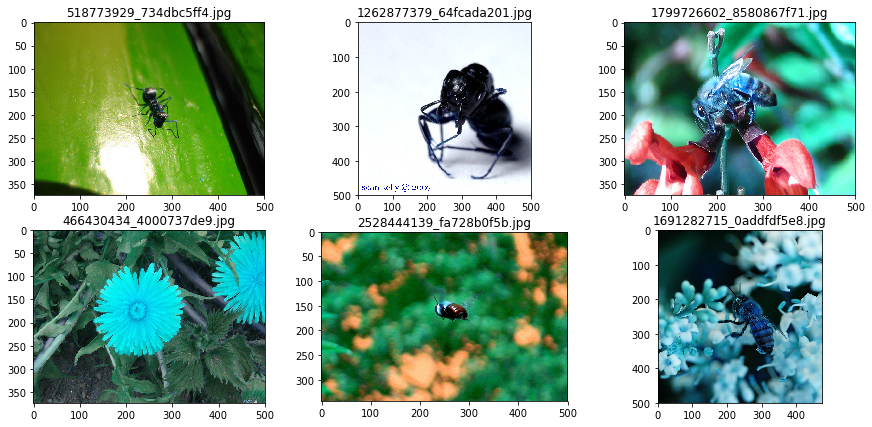

In [25]:
loader = pu.DataLoader (CSV_FILE, ROOT_DIR)
nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,7))

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(1,len(loader))
        axs[i,j].imshow(loader[idx]['image'])
        axs[i,j].set_title(loader[idx]['name'])